In [4]:
# 导入必要的库
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from typing import Dict, Any, List
from state import GraphState

# 加载环境变量
load_dotenv()

# 导入自定义节点
from nodes.init import init
from nodes.generate_storyboard import generate_storyboard
from nodes.generate_code import generate_code
from nodes.execute_python import execute_python
from nodes.fix_error import fix_error

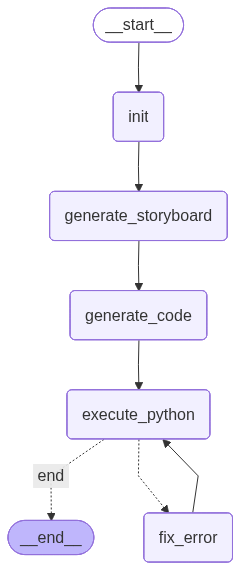

In [5]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 条件函数：判断执行是否成功
def should_continue(state: GraphState):
    """
    判断execute_python是否成功
    如果stderr为空或只包含警告，则认为成功
    """
    stderr = state.stderr or ""

    if state.config.max_retries and state.retry_count >= state.config.max_retries:
        return "end"
    
    # 如果stderr为空，或者只包含警告信息（不包含Error），则认为成功
    if not stderr or (stderr and "Error" not in stderr and "error" not in stderr):
        return "end"
    else:
        return "fix_error"

graph = StateGraph(GraphState)
graph.add_node("init", init)
graph.add_node("generate_storyboard", generate_storyboard)
graph.add_node("generate_code", generate_code)
graph.add_node("execute_python", execute_python)
graph.add_node("fix_error", fix_error)

graph.add_edge(START, "init")
graph.add_edge("init", "generate_storyboard")
graph.add_edge("generate_storyboard", "generate_code")
graph.add_edge("generate_code", "execute_python")

# 添加条件边：根据执行结果决定是结束还是修复错误
graph.add_conditional_edges(
    "execute_python",
    should_continue,
    {
        "end": END,
        "fix_error": "fix_error"
    }
)

# fix_error节点执行后返回到execute_python重新生成代码
graph.add_edge("fix_error", "execute_python")

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
def ask(question: str):
    for output in app.stream({"topic": question}, stream_mode="updates"):
        if END in output or START in output:
            continue
        # Print any node outputs
        # for key, value in output.items():
        #     if "storyboard" in value:
        #         print(value["storyboard"])


In [7]:
question = "What is binary search?"
ask(question)

======== Step 0: Initializing Project ========
Created project folder: CASES/What is binary search?/4
Attempt number: 4
======== Step 1: Generating Storyboard ========
{
  "example_name": "Binary Search for Target 37 in Sorted Array [12, 18, 23, 31, 37, 45, 52, 68, 71]",
  "storyboard": [
    {
      "step": 1,
      "visual_description": "Left 1/3: Title 'Binary Search' at top, followed by text showing 'Target: 37', 'Array: [12, 18, 23, 31, 37, 45, 52, 68, 71]', and 'Requirement: Sorted Array'. Right 2/3: A horizontal array of 9 boxes, each containing the values 12, 18, 23, 31, 37, 45, 52, 68, 71 in order, with indices 0-8 labeled below each box.",
      "animation_dsl": "Create(Text('Binary Search').to_edge(UP + LEFT)), Create(Text('Target: 37')), Create(Text('Array: [12, 18, 23, 31, 37, 45, 52, 68, 71]')), Create(VGroup(*[Square() for _ in range(9)]).arrange(RIGHT)), Create(VGroup(*[Text(str(val)) for val in [12, 18, 23, 31, 37, 45, 52, 68, 71]])), Create(VGroup(*[Text(str(i)) for i